In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

coins = ["BTC","ETH","XRP","SOL","ADA","DOGE","AVAX","DOT"]

raw_path = "eth_4hour_raw_price.csv"
feat_path = "eth_4hour_master.csv"

df_raw = pd.read_csv(raw_path)
df_raw["date"] = pd.to_datetime(df_raw["date"])

df_feat_wide = pd.read_csv(feat_path)
df_feat_wide["date"] = pd.to_datetime(df_feat_wide["date"])

df_wide_all = df_raw.merge(df_feat_wide, on="date", how="inner")

coin_prefixes = [f"{c}_" for c in coins]
all_cols = df_wide_all.columns.tolist()
global_cols = [
    c for c in all_cols
    if c not in ["date"]
    and not any(c.startswith(p) for p in coin_prefixes)
]

def wide_to_long(df_wide, coins, global_cols):
    frames = []
    for c in coins:
        base_cols = [
            "date",
            f"{c}_Open", f"{c}_High", f"{c}_Low", f"{c}_Close", f"{c}_Volume",
            f"{c}_Bin_Open", f"{c}_Bin_High", f"{c}_Bin_Low", f"{c}_Bin_Close",
        ]
        coin_cols_all = [col for col in df_wide.columns if col.startswith(f"{c}_")]
        coin_cols_other = [col for col in coin_cols_all if col not in base_cols]
        use_cols = base_cols + global_cols + coin_cols_other
        sub = df_wide[use_cols].copy()

        rename_map = {
            "date": "timestamp",
            f"{c}_Open": "open_krw",
            f"{c}_High": "high_krw",
            f"{c}_Low": "low_krw",
            f"{c}_Close": "close_krw",
            f"{c}_Volume": "volume_krw",
            f"{c}_Bin_Open": "open_usd",
            f"{c}_Bin_High": "high_usd",
            f"{c}_Bin_Low": "low_usd",
            f"{c}_Bin_Close": "close_usd",
        }
        for col in coin_cols_other:
            rename_map[col] = col.replace(f"{c}_", "")

        sub = sub.rename(columns=rename_map)
        sub["asset_id"] = c
        frames.append(sub)

    df_long = pd.concat(frames, ignore_index=True)
    df_long["timestamp"] = pd.to_datetime(df_long["timestamp"])
    df_long = df_long.sort_values(["timestamp", "asset_id"]).reset_index(drop=True)
    return df_long

df = wide_to_long(df_wide_all, coins, global_cols)

g_price = df.groupby("asset_id")["close_krw"]
df["close_krw_next"] = g_price.shift(-1)
df["log_ret_1"] = np.log(df["close_krw_next"] / df["close_krw"])

df["market_ret_1"] = df.groupby("timestamp")["log_ret_1"].transform("mean")
df["resid_ret_1"] = df["log_ret_1"] - df["market_ret_1"]

g_ret = df.groupby("asset_id")["log_ret_1"]
df["vol_30"] = (
    g_ret.rolling(window=30, min_periods=20)
        .std()
        .reset_index(level=0, drop=True)
)

df["target"] = df["resid_ret_1"] / df["vol_30"]

g_close = df.groupby("asset_id")["close_krw"]
df["ret_1"] = g_close.pct_change(1)
df["ret_4"] = g_close.pct_change(4)
df["ret_12"] = g_close.pct_change(12)
df["ret_24"] = g_close.pct_change(24)

g_vol = df.groupby("asset_id")["volume_krw"]
df["vol_chg_1"] = g_vol.pct_change(1)
df["vol_ma_12"] = (
    g_vol.rolling(window=12, min_periods=6)
        .mean()
        .reset_index(level=0, drop=True)
)
df["vol_ma_ratio_12"] = df["volume_krw"] / df["vol_ma_12"]

df["hour_sin"] = np.sin(2 * np.pi * df["timestamp"].dt.hour / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["timestamp"].dt.hour / 24)
df["dow_sin"] = np.sin(2 * np.pi * df["timestamp"].dt.dayofweek / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["timestamp"].dt.dayofweek / 7)

df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["target"]).reset_index(drop=True)
df = df.fillna(0)

le = LabelEncoder()
df["asset_id_enc"] = le.fit_transform(df["asset_id"])

drop_cols = [
    "log_ret_1", "market_ret_1", "resid_ret_1", "vol_30",
    "close_krw_next",
    "asset_id", "timestamp",
    "open_krw", "high_krw", "low_krw", "close_krw", "volume_krw",
    "open_usd", "high_usd", "low_usd", "close_usd",
]

feature_cols = [
    c for c in df.columns
    if c not in drop_cols + ["target"]
]

timestamps = np.sort(df["timestamp"].unique())
split_idx = int(len(timestamps) * 0.8)
train_ts = timestamps[:split_idx]
valid_ts = timestamps[split_idx:]

train_mask = df["timestamp"].isin(train_ts)
valid_mask = df["timestamp"].isin(valid_ts)

all_features = feature_cols.copy()
X_full = df[all_features]

nunique = X_full.nunique(dropna=True)
mask_var = nunique > 1
features_var = nunique[mask_var].index.tolist()

na_ratio = X_full[features_var].isna().mean()
mask_na = na_ratio < 0.5
features_clean = na_ratio[mask_na].index.tolist()

must_keep = ["asset_id_enc"]
for col in must_keep:
    if col in df.columns and col not in features_clean:
        features_clean.append(col)

X_train_full = df.loc[train_mask, features_clean]
X_valid_full = df.loc[valid_mask, features_clean]
y_train = df.loc[train_mask, "target"]
y_valid = df.loc[valid_mask, "target"]

train_dataset_full = lgb.Dataset(
    X_train_full,
    label=y_train,
    categorical_feature=[c for c in must_keep if c in features_clean]
)
valid_dataset_full = lgb.Dataset(
    X_valid_full,
    label=y_valid,
    categorical_feature=[c for c in must_keep if c in features_clean]
)

params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 63,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "min_data_in_leaf": 50,
    "verbose": -1,
}

callbacks = [
    lgb.early_stopping(stopping_rounds=100),
    lgb.log_evaluation(period=200),
]

model_full = lgb.train(
    params=params,
    train_set=train_dataset_full,
    num_boost_round=2000,
    valid_sets=[train_dataset_full, valid_dataset_full],
    valid_names=["train", "valid"],
    callbacks=callbacks
)

imp_gain = model_full.feature_importance(importance_type="gain")
importance_series = pd.Series(imp_gain, index=features_clean).sort_values(ascending=False)

def compute_equity_metrics(equity_df):
    eq = equity_df["equity"].values.astype(float)
    peak = np.maximum.accumulate(eq)
    dd = eq / peak - 1.0
    mdd = float(dd.min())
    final_ret = float(eq[-1] - 1.0)
    return final_ret, mdd



Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4]	train's rmse: 0.69958	valid's rmse: 0.709672


In [12]:
TOP_N_list = [5, 10, 20, 30]
fee_list = [0.0005]
top_k_list = [1, 2, 3]

results = []

for TOP_N in TOP_N_list:
    top_features = importance_series.head(TOP_N).index.tolist()
    for col in must_keep:
        if col in df.columns and col not in top_features:
            top_features.append(col)

    X_train_sel = df.loc[train_mask, top_features]
    X_valid_sel = df.loc[valid_mask, top_features]

    train_dataset_sel = lgb.Dataset(
        X_train_sel,
        label=y_train,
        categorical_feature=[c for c in must_keep if c in top_features]
    )
    valid_dataset_sel = lgb.Dataset(
        X_valid_sel,
        label=y_valid,
        categorical_feature=[c for c in must_keep if c in top_features]
    )

    model_sel = lgb.train(
        params=params,
        train_set=train_dataset_sel,
        num_boost_round=2000,
        valid_sets=[train_dataset_sel, valid_dataset_sel],
        valid_names=["train", "valid"],
        callbacks=callbacks
    )

    df_valid = df.loc[valid_mask].copy()
    df_valid["y_pred"] = model_sel.predict(X_valid_sel, num_iteration=model_sel.best_iteration)
    df_valid = df_valid.sort_values(["timestamp","asset_id"]).reset_index(drop=True)

    ics = []
    for ts, g in df_valid.groupby("timestamp"):
        g_sorted = g.sort_values("y_pred", ascending=False)
        long_assets = g_sorted.head(top_k)
        ret_realized = long_assets["log_ret_1"].mean()
        ret_after_fee = ret_realized - fee
        capital = capital * np.exp(ret_after_fee)

    single_mean_ic = float(np.mean(ics))

    for fee in fee_list:
        for top_k in top_k_list:
            capital = 1.0
            equity_curve = []
            for ts, g in df_valid.groupby("timestamp"):
                g_sorted = g.sort_values("y_pred", ascending=False)
                long_assets = g_sorted.head(top_k)
                ret_realized = long_assets["log_ret_1"].mean()
                ret_after_fee = ret_realized - fee
                capital = capital * np.exp(ret_after_fee)
                equity_curve.append({"timestamp": ts, "equity": capital})
            equity_df = pd.DataFrame(equity_curve).sort_values("timestamp").reset_index(drop=True)
            single_final_ret, single_mdd = compute_equity_metrics(equity_df)

            years = sorted(df["timestamp"].dt.year.unique())
            wf_rows = []
            wf_ic_list = []
            for end_year in [2021, 2022, 2023, 2024]:
                train_mask_wf = df["timestamp"].dt.year <= end_year
                test_mask_wf = (df["timestamp"].dt.year == end_year + 1)
                if not test_mask_wf.any():
                    continue

                X_train_wf = df.loc[train_mask_wf, top_features]
                y_train_wf = df.loc[train_mask_wf, "target"]
                X_test_wf = df.loc[test_mask_wf, top_features]
                y_test_wf = df.loc[test_mask_wf, "target"]

                train_ds = lgb.Dataset(
                    X_train_wf,
                    label=y_train_wf,
                    categorical_feature=[c for c in must_keep if c in top_features]
                )
                valid_ds = lgb.Dataset(
                    X_test_wf,
                    label=y_test_wf,
                    categorical_feature=[c for c in must_keep if c in top_features]
                )

                model_wf = lgb.train(
                    params=params,
                    train_set=train_ds,
                    num_boost_round=2000,
                    valid_sets=[train_ds, valid_ds],
                    valid_names=["train","valid"],
                    callbacks=callbacks
                )

                df_test = df.loc[test_mask_wf].copy()
                df_test["y_pred"] = model_wf.predict(X_test_wf, num_iteration=model_wf.best_iteration)
                df_test = df_test.sort_values(["timestamp","asset_id"])

                ics_wf = []
                for ts2, g2 in df_test.groupby("timestamp"):
                    if g2["y_pred"].nunique() > 1 and g2["target"].nunique() > 1:
                        ic2 = np.corrcoef(g2["y_pred"], g2["target"])[0, 1]
                        ics_wf.append(ic2)
                mean_ic_wf = float(np.mean(ics_wf)) if len(ics_wf) > 0 else np.nan
                wf_ic_list.append(mean_ic_wf)

                capital_wf = 1.0
                equity_curve_wf = []
                for ts2, g2 in df_test.groupby("timestamp"):
                    g_sorted2 = g2.sort_values("y_pred", ascending=False)
                    long_assets2 = g_sorted2.head(top_k)
                    ret_realized2 = long_assets2["log_ret_1"].mean()
                    ret_after_fee2 = ret_realized2 - fee
                    capital_wf *= np.exp(ret_after_fee2)
                    equity_curve_wf.append({"timestamp": ts2, "equity": capital_wf})
                equity_wf = pd.DataFrame(equity_curve_wf).sort_values("timestamp").reset_index(drop=True)
                wf_final_ret, wf_mdd = compute_equity_metrics(equity_wf)

                results.append({
                    "mode": "walk_forward",
                    "end_year": end_year,
                    "TOP_N": TOP_N,
                    "fee": fee,
                    "top_k": top_k,
                    "mean_ic": mean_ic_wf,
                    "final_return": wf_final_ret,
                    "mdd": wf_mdd
                })

            wf_mean_ic_over_years = float(np.nanmean(wf_ic_list)) if len(wf_ic_list) > 0 else np.nan

            results.append({
                "mode": "single_split",
                "end_year": "all",
                "TOP_N": TOP_N,
                "fee": fee,
                "top_k": top_k,
                "mean_ic": single_mean_ic,
                "final_return": single_final_ret,
                "mdd": single_mdd,
                "wf_mean_ic_over_years": wf_mean_ic_over_years
            })

results_df = pd.DataFrame(results)
results_df.to_csv("grid_results_4h_multi_asset.csv", index=False)
print(results_df.head())
print(results_df.tail())



Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.678941	valid's rmse: 0.710424
Early stopping, best iteration is:
[6]	train's rmse: 0.701116	valid's rmse: 0.707152
Base only mean_IC: 0.015324070224837928
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.671889	valid's rmse: 0.710768
Early stopping, best iteration is:
[3]	train's rmse: 0.701724	valid's rmse: 0.707097
Base + TA Trend mean_IC: 0.028561822694131492
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.668572	valid's rmse: 0.709135
Early stopping, best iteration is:
[10]	train's rmse: 0.697595	valid's rmse: 0.70689
Base + Trend + Momentum mean_IC: 0.030854386994006743
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.661382	valid's rmse: 0.709744
Early stopping, best iteration is:
[3]	train's rmse: 0.70098	valid's rmse: 0.707123
Full feature set mean_IC: 0.02987504933580231


Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.580977	test's rmse: 0.65439
Early stopping, best iteration is:
[128]	train's rmse: 0.569554	test's rmse: 0.65348

=== Test Period Results (2025-01-01 ~) ===
Final Return: -29.31%
Max Drawdown: -52.88%
Sharpe Ratio: -0.47
Total Trades: 334


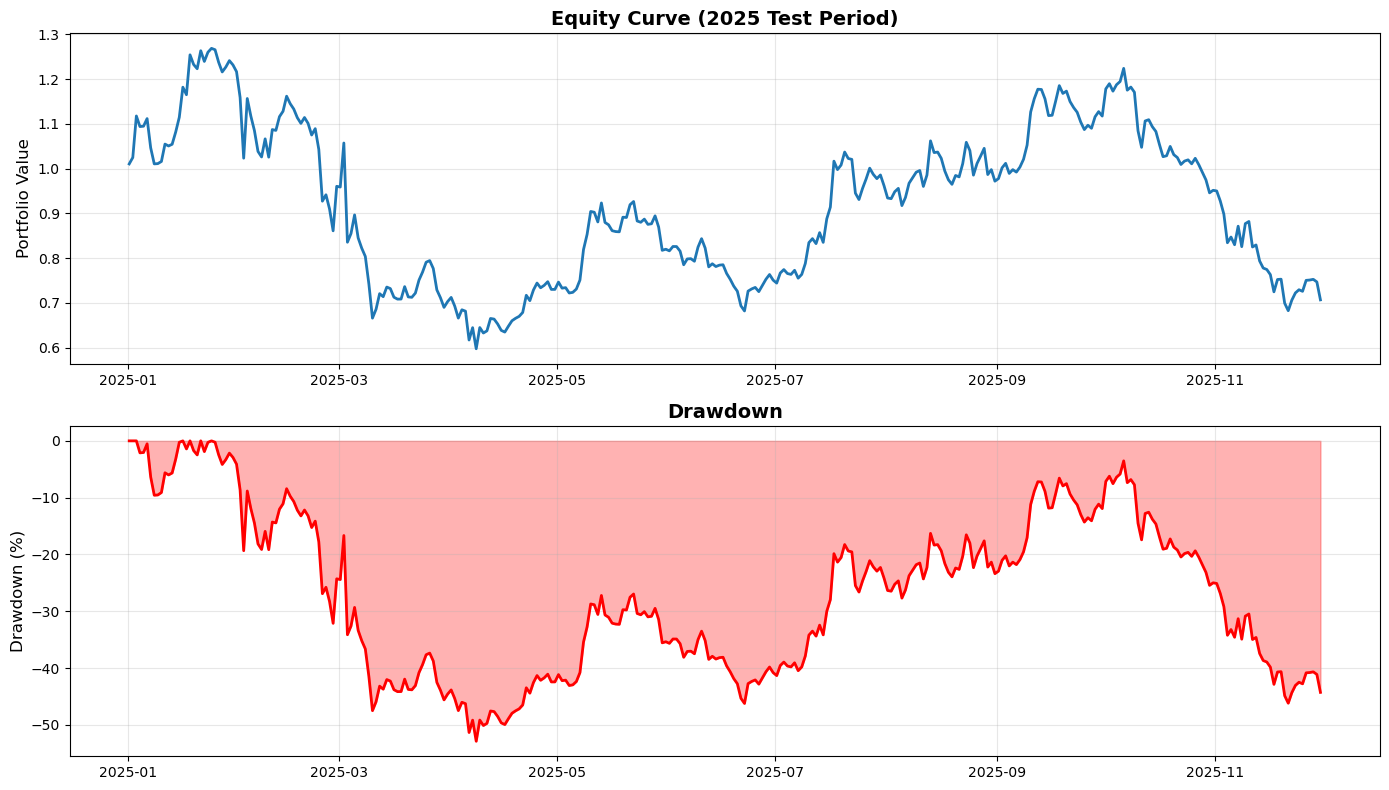

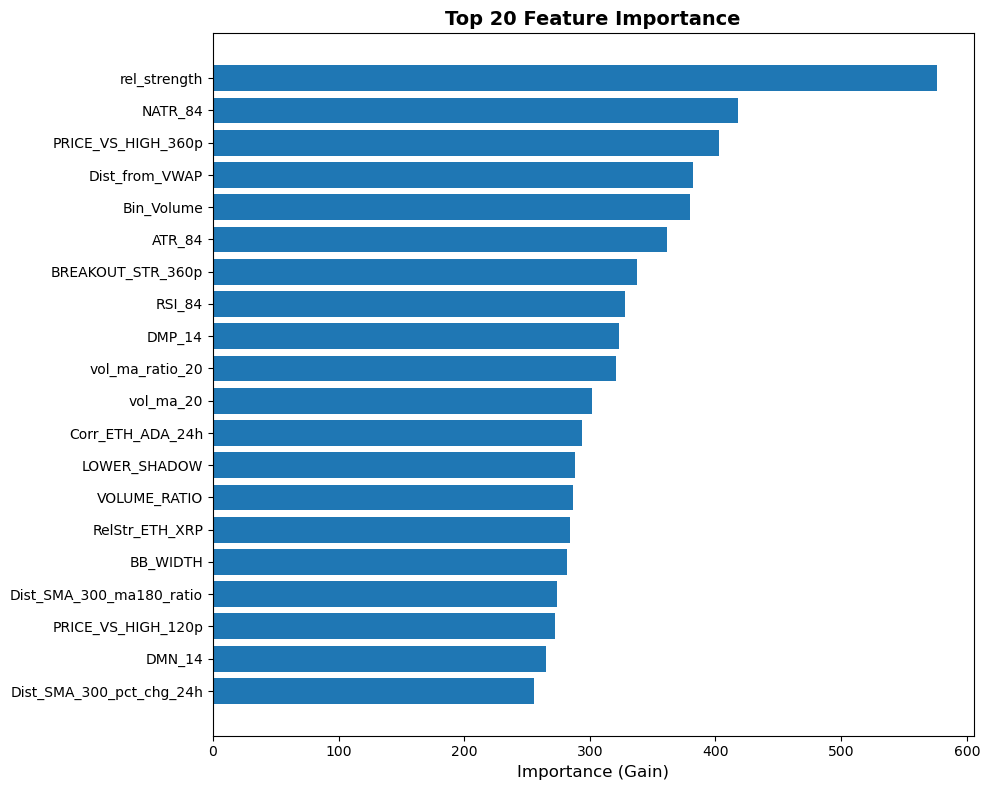

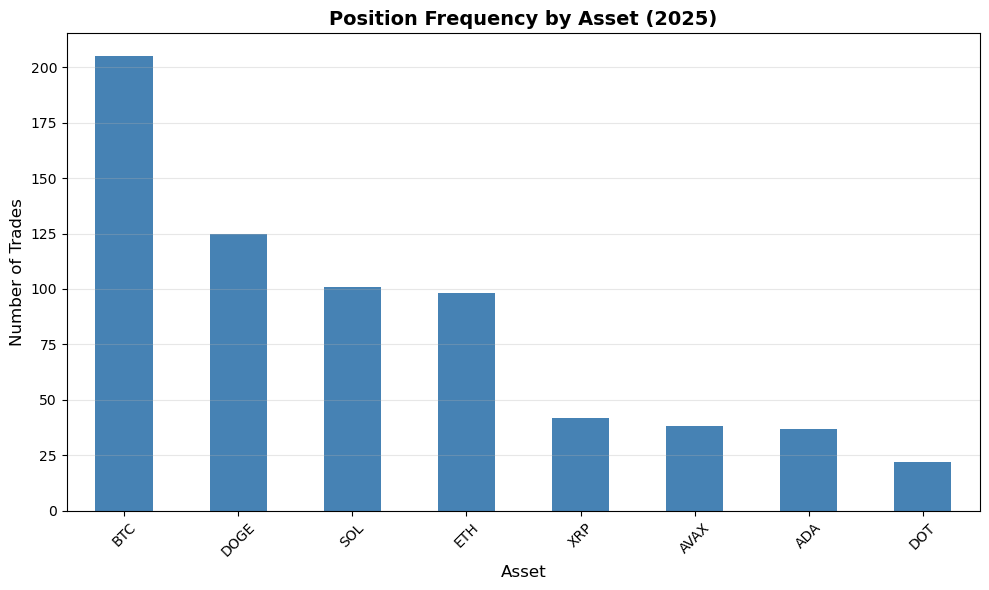


=== Position Distribution ===
BTC     205
DOGE    125
SOL     101
ETH      98
XRP      42
AVAX     38
ADA      37
DOT      22
dtype: int64


In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

coins = ["BTC","ETH","XRP","SOL","ADA","DOGE","AVAX","DOT"]

raw_path = "eth_4hour_raw_price.csv"
feat_path = "eth_4hour_master.csv"

df_raw = pd.read_csv(raw_path)
df_raw["date"] = pd.to_datetime(df_raw["date"])

df_feat_wide = pd.read_csv(feat_path)
df_feat_wide["date"] = pd.to_datetime(df_feat_wide["date"])

df_wide_all = df_raw.merge(df_feat_wide, on="date", how="inner")

coin_prefixes = [f"{c}_" for c in coins]
all_cols = df_wide_all.columns.tolist()
global_cols = [
    c for c in all_cols
    if c not in ["date"]
    and not any(c.startswith(p) for p in coin_prefixes)
]

def wide_to_long(df_wide, coins, global_cols):
    frames = []
    for c in coins:
        base_cols = [
            "date",
            f"{c}_Open", f"{c}_High", f"{c}_Low", f"{c}_Close", f"{c}_Volume",
            f"{c}_Bin_Open", f"{c}_Bin_High", f"{c}_Bin_Low", f"{c}_Bin_Close",
        ]
        coin_cols_all = [col for col in df_wide.columns if col.startswith(f"{c}_")]
        coin_cols_other = [col for col in coin_cols_all if col not in base_cols]
        use_cols = base_cols + global_cols + coin_cols_other
        sub = df_wide[use_cols].copy()

        rename_map = {
            "date": "timestamp",
            f"{c}_Open": "open_krw",
            f"{c}_High": "high_krw",
            f"{c}_Low": "low_krw",
            f"{c}_Close": "close_krw",
            f"{c}_Volume": "volume_krw",
            f"{c}_Bin_Open": "open_usd",
            f"{c}_Bin_High": "high_usd",
            f"{c}_Bin_Low": "low_usd",
            f"{c}_Bin_Close": "close_usd",
        }
        for col in coin_cols_other:
            rename_map[col] = col.replace(f"{c}_", "")

        sub = sub.rename(columns=rename_map)
        sub["asset_id"] = c
        frames.append(sub)

    df_long = pd.concat(frames, ignore_index=True)
    df_long["timestamp"] = pd.to_datetime(df_long["timestamp"])
    df_long = df_long.sort_values(["timestamp", "asset_id"]).reset_index(drop=True)
    return df_long

df = wide_to_long(df_wide_all, coins, global_cols)

df = df[df["timestamp"].dt.hour == 9].reset_index(drop=True)

g_price = df.groupby("asset_id")["close_krw"]
df["close_krw_next"] = g_price.shift(-1)
df["log_ret_1"] = np.log(df["close_krw_next"] / df["close_krw"])

df["market_ret_1"] = df.groupby("timestamp")["log_ret_1"].transform("mean")
df["resid_ret_1"] = df["log_ret_1"] - df["market_ret_1"]

g_ret = df.groupby("asset_id")["log_ret_1"]
df["vol_30"] = (
    g_ret.rolling(window=30, min_periods=20)
        .std()
        .reset_index(level=0, drop=True)
)

df["target_raw"] = df["resid_ret_1"] / df["vol_30"]
df["target"] = df["target_raw"].clip(-3, 3)

g_close = df.groupby("asset_id")["close_krw"]
for lag in [1, 5, 10, 20]:
    df[f"ret_{lag}"] = g_close.pct_change(lag)

g_vol = df.groupby("asset_id")["volume_krw"]
df["vol_chg_1"] = g_vol.pct_change(1)
df["vol_ma_20"] = (
    g_vol.rolling(window=20, min_periods=10)
        .mean()
        .reset_index(level=0, drop=True)
)
df["vol_ma_ratio_20"] = df["volume_krw"] / df["vol_ma_20"]

for ts_idx, group in df.groupby("timestamp"):
    if len(group) < 2:
        continue
    rets = group.set_index("asset_id")["ret_1"]
    for _, row in group.iterrows():
        asset = row["asset_id"]
        others_ret = rets.drop(asset).mean()
        df.loc[(df["timestamp"]==ts_idx) & (df["asset_id"]==asset), "rel_strength"] = rets[asset] - others_ret

df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["target"]).reset_index(drop=True)
df = df.fillna(0)

le = LabelEncoder()
df["asset_id_enc"] = le.fit_transform(df["asset_id"])

drop_cols = [
    "log_ret_1", "market_ret_1", "resid_ret_1", "vol_30", "target_raw",
    "close_krw_next",
    "asset_id", "timestamp",
    "open_krw", "high_krw", "low_krw", "close_krw", "volume_krw",
    "open_usd", "high_usd", "low_usd", "close_usd",
]

feature_cols = [
    c for c in df.columns
    if c not in drop_cols + ["target"]
]

timestamps = np.sort(df["timestamp"].unique())

train_cutoff = pd.Timestamp("2024-12-31")
test_cutoff = pd.Timestamp("2025-01-01")

train_mask = df["timestamp"] < train_cutoff
test_mask = df["timestamp"] >= test_cutoff

X_full = df[feature_cols]
nunique = X_full.nunique(dropna=True)
mask_var = nunique > 1
features_var = nunique[mask_var].index.tolist()

na_ratio = X_full[features_var].isna().mean()
mask_na = na_ratio < 0.5
features_clean = na_ratio[mask_na].index.tolist()

must_keep = ["asset_id_enc"]
for col in must_keep:
    if col in df.columns and col not in features_clean:
        features_clean.append(col)

X_train = df.loc[train_mask, features_clean]
X_test = df.loc[test_mask, features_clean]
y_train = df.loc[train_mask, "target"]
y_test = df.loc[test_mask, "target"]

train_dataset = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=[c for c in must_keep if c in features_clean]
)
test_dataset = lgb.Dataset(
    X_test,
    label=y_test,
    categorical_feature=[c for c in must_keep if c in features_clean]
)

params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.03,
    "num_leaves": 31,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.7,
    "bagging_freq": 5,
    "min_data_in_leaf": 30,
    "verbose": -1,
}

callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=100),
]

model = lgb.train(
    params=params,
    train_set=train_dataset,
    num_boost_round=1000,
    valid_sets=[train_dataset, test_dataset],
    valid_names=["train", "test"],
    callbacks=callbacks
)

df_test = df.loc[test_mask].copy()
df_test["y_pred"] = model.predict(X_test, num_iteration=model.best_iteration)
df_test = df_test.sort_values(["timestamp","asset_id"]).reset_index(drop=True)

fee = 0.0005
top_k = 2

capital = 1.0
equity_curve = []
position_history = []

for ts, g in df_test.groupby("timestamp"):
    g_sorted = g.sort_values("y_pred", ascending=False)
    long_assets = g_sorted.head(top_k)
    
    ret_realized = long_assets["log_ret_1"].mean()
    ret_after_fee = ret_realized - fee
    capital = capital * np.exp(ret_after_fee)
    
    equity_curve.append({"timestamp": ts, "equity": capital})
    position_history.append({
        "timestamp": ts,
        "positions": long_assets["asset_id"].tolist()
    })

equity_df = pd.DataFrame(equity_curve).sort_values("timestamp").reset_index(drop=True)

eq = equity_df["equity"].values
peak = np.maximum.accumulate(eq)
dd = eq / peak - 1.0
mdd = float(dd.min())
final_ret = float(eq[-1] - 1.0)

returns = np.diff(np.log(eq))
sharpe = float(returns.mean() / returns.std() * np.sqrt(252)) if returns.std() > 0 else 0

print(f"\n=== Test Period Results (2025-01-01 ~) ===")
print(f"Final Return: {final_ret*100:.2f}%")
print(f"Max Drawdown: {mdd*100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Total Trades: {len(equity_curve)}")

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(equity_df["timestamp"], equity_df["equity"], linewidth=2)
plt.title("Equity Curve (2025 Test Period)", fontsize=14, fontweight='bold')
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(equity_df["timestamp"], dd * 100, color='red', linewidth=2)
plt.fill_between(equity_df["timestamp"], dd * 100, 0, alpha=0.3, color='red')
plt.title("Drawdown", fontsize=14, fontweight='bold')
plt.ylabel("Drawdown (%)", fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("strategy_performance_2025.png", dpi=300, bbox_inches='tight')
plt.show()

importance_gain = model.feature_importance(importance_type="gain")
importance_df = pd.DataFrame({
    "feature": features_clean,
    "importance": importance_gain
}).sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(importance_df["feature"], importance_df["importance"])
plt.xlabel("Importance (Gain)", fontsize=12)
plt.title("Top 20 Feature Importance", fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

position_df = pd.DataFrame(position_history)
all_positions = []
for _, row in position_df.iterrows():
    for pos in row["positions"]:
        all_positions.append(pos)
        
pos_counts = pd.Series(all_positions).value_counts()

plt.figure(figsize=(10, 6))
pos_counts.plot(kind='bar', color='steelblue')
plt.title("Position Frequency by Asset (2025)", fontsize=14, fontweight='bold')
plt.ylabel("Number of Trades", fontsize=12)
plt.xlabel("Asset", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("position_frequency.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n=== Position Distribution ===")
print(pos_counts)

Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 1.37296	valid's multi_logloss: 1.54269
[200]	train's multi_logloss: 1.25305	valid's multi_logloss: 1.54609
Early stopping, best iteration is:
[146]	train's multi_logloss: 1.31292	valid's multi_logloss: 1.54063

=== Test Period Results (2025-01-01 ~) ===
Final Return: -85.60%
Max Drawdown: -87.72%
Sharpe Ratio: -1.77
Win Rate: 43.24%
Total Trades: 334


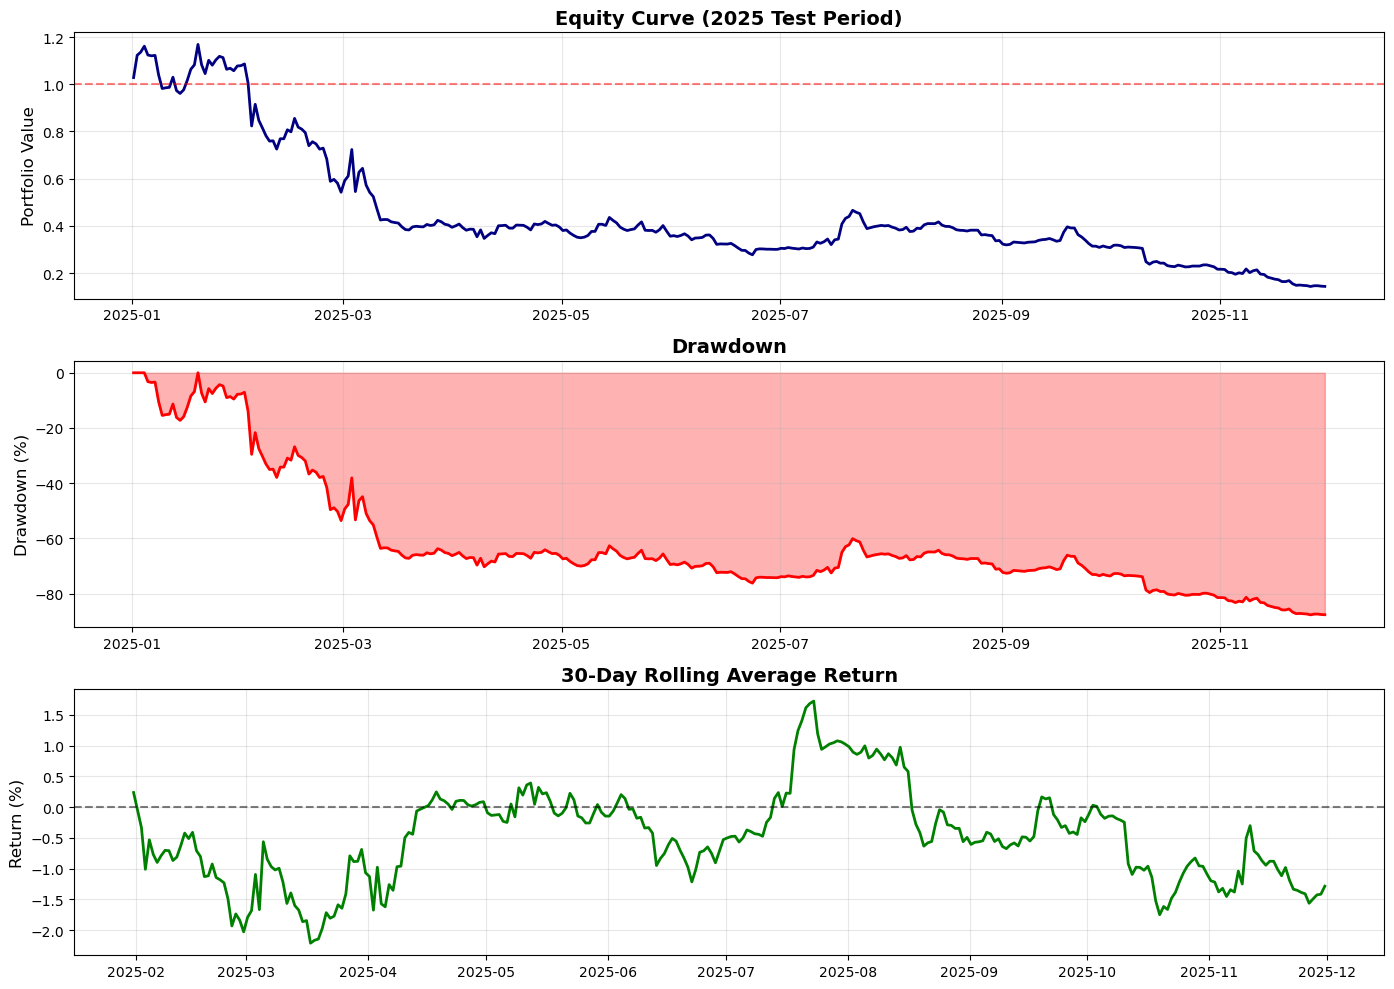

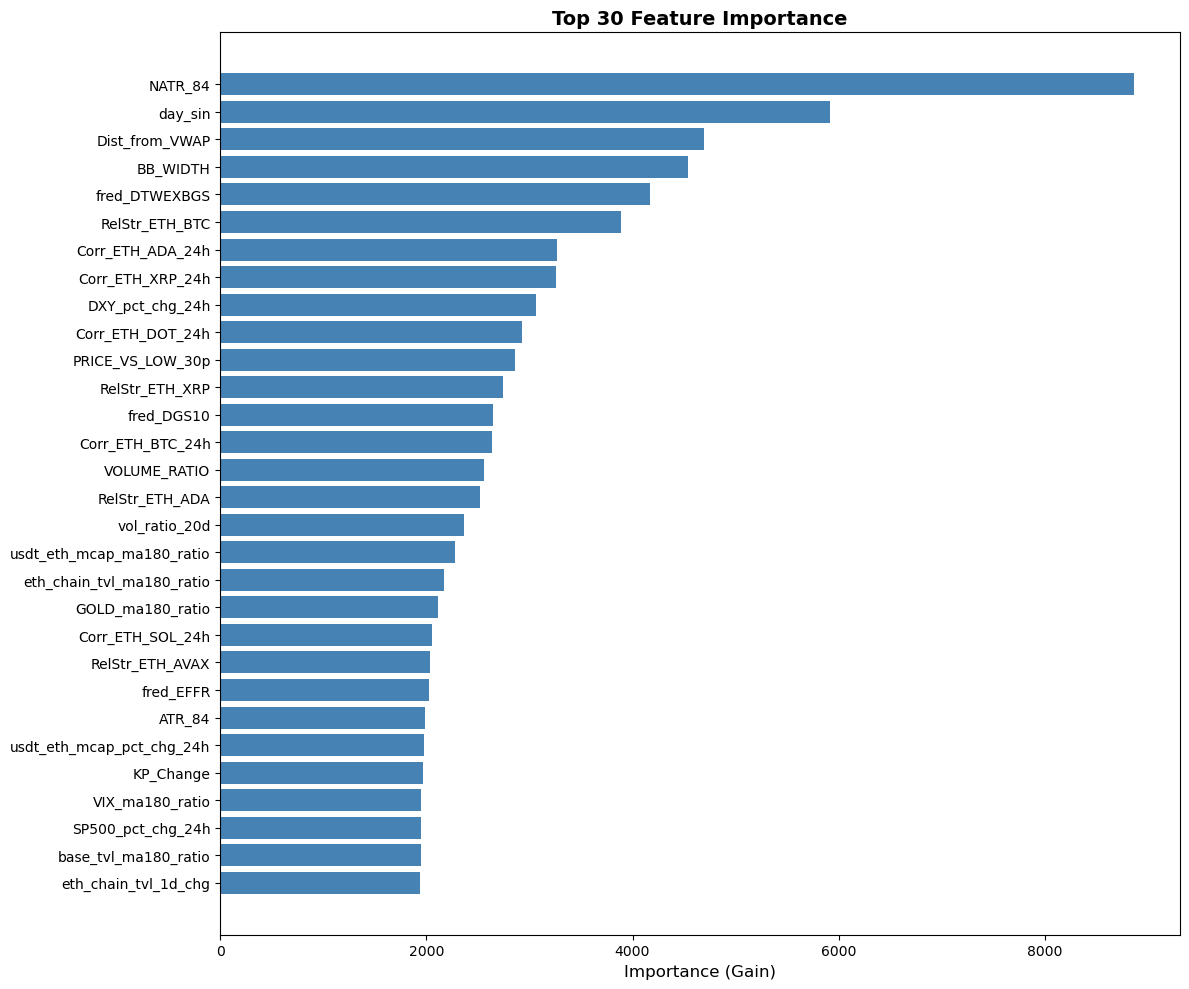

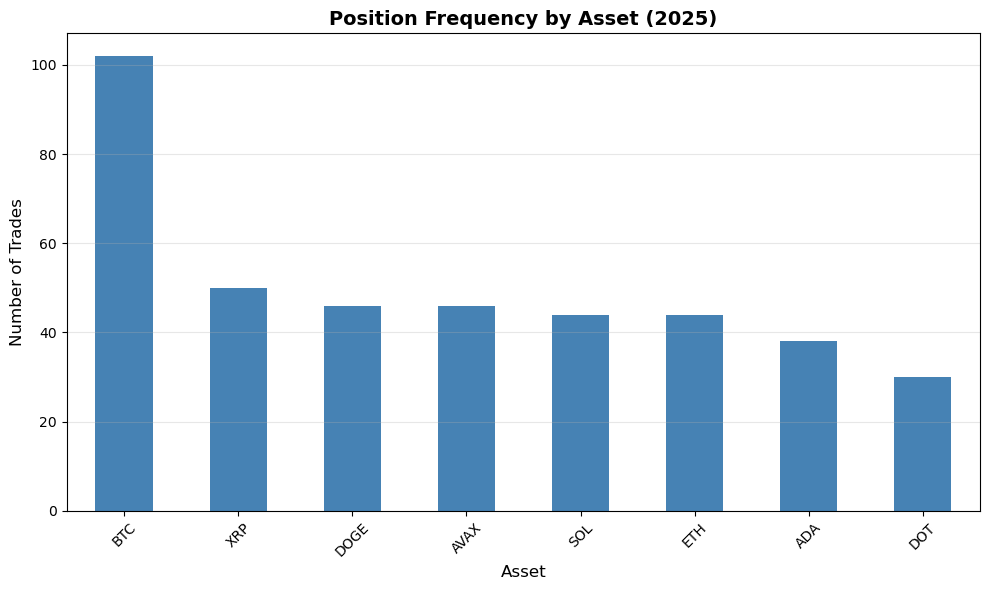


=== Position Distribution ===
BTC     102
XRP      50
DOGE     46
AVAX     46
SOL      44
ETH      44
ADA      38
DOT      30
dtype: int64

=== Monthly Returns ===
            start       end     return
month                                 
2025-01  1.028275  1.078820   4.915436
2025-02  1.086002  0.542758 -50.022340
2025-03  0.591583  0.394217 -33.362384
2025-04  0.400259  0.395759  -1.124254
2025-05  0.380577  0.356623  -6.294164
2025-06  0.358781  0.300872 -16.140639
2025-07  0.305239  0.401777  31.627114
2025-08  0.395219  0.338395 -14.377956
2025-09  0.322794  0.310542  -3.795561
2025-10  0.307900  0.216700 -29.620026
2025-11  0.216648  0.143977 -33.543588


In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, RobustScaler
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

coins = ["BTC","ETH","XRP","SOL","ADA","DOGE","AVAX","DOT"]

raw_path = "eth_4hour_raw_price.csv"
feat_path = "eth_4hour_master.csv"

df_raw = pd.read_csv(raw_path)
df_raw["date"] = pd.to_datetime(df_raw["date"])

df_feat_wide = pd.read_csv(feat_path)
df_feat_wide["date"] = pd.to_datetime(df_feat_wide["date"])

df_wide_all = df_raw.merge(df_feat_wide, on="date", how="inner")

coin_prefixes = [f"{c}_" for c in coins]
all_cols = df_wide_all.columns.tolist()
global_cols = [
    c for c in all_cols
    if c not in ["date"]
    and not any(c.startswith(p) for p in coin_prefixes)
]

def wide_to_long(df_wide, coins, global_cols):
    frames = []
    for c in coins:
        base_cols = [
            "date",
            f"{c}_Open", f"{c}_High", f"{c}_Low", f"{c}_Close", f"{c}_Volume",
            f"{c}_Bin_Open", f"{c}_Bin_High", f"{c}_Bin_Low", f"{c}_Bin_Close",
        ]
        coin_cols_all = [col for col in df_wide.columns if col.startswith(f"{c}_")]
        coin_cols_other = [col for col in coin_cols_all if col not in base_cols]
        use_cols = base_cols + global_cols + coin_cols_other
        sub = df_wide[use_cols].copy()

        rename_map = {
            "date": "timestamp",
            f"{c}_Open": "open_krw",
            f"{c}_High": "high_krw",
            f"{c}_Low": "low_krw",
            f"{c}_Close": "close_krw",
            f"{c}_Volume": "volume_krw",
            f"{c}_Bin_Open": "open_usd",
            f"{c}_Bin_High": "high_usd",
            f"{c}_Bin_Low": "low_usd",
            f"{c}_Bin_Close": "close_usd",
        }
        for col in coin_cols_other:
            rename_map[col] = col.replace(f"{c}_", "")

        sub = sub.rename(columns=rename_map)
        sub["asset_id"] = c
        frames.append(sub)

    df_long = pd.concat(frames, ignore_index=True)
    df_long["timestamp"] = pd.to_datetime(df_long["timestamp"])
    df_long = df_long.sort_values(["timestamp", "asset_id"]).reset_index(drop=True)
    return df_long

df = wide_to_long(df_wide_all, coins, global_cols)

df = df[df["timestamp"].dt.hour == 9].reset_index(drop=True)

g_price = df.groupby("asset_id")["close_krw"]
df["close_krw_next"] = g_price.shift(-1)
df["ret_1d"] = (df["close_krw_next"] / df["close_krw"]) - 1

df["target"] = df.groupby("asset_id")["ret_1d"].transform(
    lambda x: pd.qcut(x, q=5, labels=False, duplicates='drop')
)

g_close = df.groupby("asset_id")["close_krw"]
for lag in [1, 3, 7, 14, 30]:
    df[f"ret_{lag}d"] = g_close.pct_change(lag)
    df[f"mom_{lag}d"] = g_close.pct_change(lag) / g_close.pct_change(lag).rolling(20).std()

g_vol = df.groupby("asset_id")["volume_krw"]
for lag in [1, 7]:
    df[f"vol_chg_{lag}d"] = g_vol.pct_change(lag)

df["vol_ma_20d"] = g_vol.rolling(20).mean().reset_index(level=0, drop=True)
df["vol_ratio_20d"] = df["volume_krw"] / df["vol_ma_20d"]

for window in [7, 14, 30]:
    df[f"ret_volatility_{window}d"] = (
        df.groupby("asset_id")["ret_1d"]
        .rolling(window)
        .std()
        .reset_index(level=0, drop=True)
    )

for ts_idx, group in df.groupby("timestamp"):
    if len(group) < 2:
        continue
    for lag in [1, 7]:
        ret_col = f"ret_{lag}d"
        if ret_col not in group.columns:
            continue
        rets = group.set_index("asset_id")[ret_col]
        rank = rets.rank(pct=True)
        for asset in group["asset_id"]:
            df.loc[(df["timestamp"]==ts_idx) & (df["asset_id"]==asset), f"cross_rank_{lag}d"] = rank[asset]

rsi_cols = [c for c in df.columns if "RSI" in c]
for col in rsi_cols:
    df[f"{col}_signal"] = 0
    df.loc[df[col] < 30, f"{col}_signal"] = 1
    df.loc[df[col] > 70, f"{col}_signal"] = -1

macd_cols = [c for c in df.columns if "MACD" in c and "Pct" in c]
for col in macd_cols:
    df[f"{col}_sign"] = np.sign(df[col])

trend_cols = [c for c in df.columns if "TREND_SCORE" in c or "REGIME" in c]

volume_cols = [c for c in df.columns if "VOLUME_RATIO" in c or "MFI" in c]

df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["target"]).reset_index(drop=True)

numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col not in ["target", "ret_1d"]:
        df[col] = df[col].fillna(df[col].median())

le = LabelEncoder()
df["asset_id_enc"] = le.fit_transform(df["asset_id"])

drop_cols = [
    "ret_1d", "close_krw_next",
    "asset_id", "timestamp",
    "open_krw", "high_krw", "low_krw", "close_krw", "volume_krw",
    "open_usd", "high_usd", "low_usd", "close_usd",
]

feature_cols = [
    c for c in df.columns
    if c not in drop_cols + ["target"]
]

train_cutoff = pd.Timestamp("2024-01-01")
valid_cutoff = pd.Timestamp("2024-10-01")
test_cutoff = pd.Timestamp("2025-01-01")

train_mask = df["timestamp"] < valid_cutoff
valid_mask = (df["timestamp"] >= valid_cutoff) & (df["timestamp"] < test_cutoff)
test_mask = df["timestamp"] >= test_cutoff

X_full = df[feature_cols]
nunique = X_full.nunique(dropna=True)
mask_var = nunique > 1
features_var = nunique[mask_var].index.tolist()

na_ratio = X_full[features_var].isna().mean()
mask_na = na_ratio < 0.3
features_clean = na_ratio[mask_na].index.tolist()

must_keep = ["asset_id_enc"]
for col in must_keep:
    if col in df.columns and col not in features_clean:
        features_clean.append(col)

X_train = df.loc[train_mask, features_clean]
X_valid = df.loc[valid_mask, features_clean]
X_test = df.loc[test_mask, features_clean]
y_train = df.loc[train_mask, "target"]
y_valid = df.loc[valid_mask, "target"]
y_test = df.loc[test_mask, "target"]

train_dataset = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=[c for c in must_keep if c in features_clean]
)
valid_dataset = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=[c for c in must_keep if c in features_clean]
)

params = {
    "objective": "multiclass",
    "num_class": 5,
    "metric": "multi_logloss",
    "learning_rate": 0.02,
    "num_leaves": 31,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "bagging_freq": 5,
    "min_data_in_leaf": 50,
    "max_depth": 5,
    "verbose": -1,
}

callbacks = [
    lgb.early_stopping(stopping_rounds=100),
    lgb.log_evaluation(period=100),
]

model = lgb.train(
    params=params,
    train_set=train_dataset,
    num_boost_round=1000,
    valid_sets=[train_dataset, valid_dataset],
    valid_names=["train", "valid"],
    callbacks=callbacks
)

df_test = df.loc[test_mask].copy()
pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
df_test["pred_class"] = np.argmax(pred_proba, axis=1)
df_test["pred_top_proba"] = np.max(pred_proba, axis=1)

df_test["composite_score"] = df_test["pred_class"] * df_test["pred_top_proba"]

df_test = df_test.sort_values(["timestamp","asset_id"]).reset_index(drop=True)

fee = 0.0005
max_positions = 3
min_score_threshold = 2.0
stop_loss = -0.15

capital = 1.0
equity_curve = []
position_history = []
drawdown_protection = False

for ts, g in df_test.groupby("timestamp"):
    current_equity = capital
    
    if current_equity < 0.5:
        drawdown_protection = True
    
    if drawdown_protection:
        top_k = 1
    else:
        avg_vol = g["ret_volatility_7d"].mean()
        if avg_vol > 0.05:
            top_k = 1
        elif avg_vol > 0.03:
            top_k = 2
        else:
            top_k = max_positions
    
    g_filtered = g[g["composite_score"] >= min_score_threshold]
    
    if len(g_filtered) == 0:
        g_filtered = g
    
    g_sorted = g_filtered.sort_values("composite_score", ascending=False)
    long_assets = g_sorted.head(top_k)
    
    returns = long_assets["ret_1d"].values
    
    for ret in returns:
        if ret < stop_loss:
            ret = stop_loss
    
    ret_realized = np.mean(returns)
    ret_after_fee = ret_realized - fee
    
    capital = capital * (1 + ret_after_fee)
    
    equity_curve.append({"timestamp": ts, "equity": capital})
    position_history.append({
        "timestamp": ts,
        "positions": long_assets["asset_id"].tolist(),
        "scores": long_assets["composite_score"].tolist()
    })

equity_df = pd.DataFrame(equity_curve).sort_values("timestamp").reset_index(drop=True)

eq = equity_df["equity"].values
peak = np.maximum.accumulate(eq)
dd = eq / peak - 1.0
mdd = float(dd.min())
final_ret = float(eq[-1] - 1.0)

returns = np.diff(eq) / eq[:-1]
sharpe = float(returns.mean() / returns.std() * np.sqrt(252)) if returns.std() > 0 else 0

win_rate = float((returns > 0).sum() / len(returns)) if len(returns) > 0 else 0

print(f"\n=== Test Period Results (2025-01-01 ~) ===")
print(f"Final Return: {final_ret*100:.2f}%")
print(f"Max Drawdown: {mdd*100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Win Rate: {win_rate*100:.2f}%")
print(f"Total Trades: {len(equity_curve)}")

plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(equity_df["timestamp"], equity_df["equity"], linewidth=2, color='navy')
plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)
plt.title("Equity Curve (2025 Test Period)", fontsize=14, fontweight='bold')
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(equity_df["timestamp"], dd * 100, color='red', linewidth=2)
plt.fill_between(equity_df["timestamp"], dd * 100, 0, alpha=0.3, color='red')
plt.title("Drawdown", fontsize=14, fontweight='bold')
plt.ylabel("Drawdown (%)", fontsize=12)
plt.grid(alpha=0.3)

plt.subplot(3, 1, 3)
rolling_returns = pd.Series(returns).rolling(30).mean() * 100
plt.plot(equity_df["timestamp"][1:], rolling_returns, color='green', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title("30-Day Rolling Average Return", fontsize=14, fontweight='bold')
plt.ylabel("Return (%)", fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("strategy_performance_2025_v2.png", dpi=300, bbox_inches='tight')
plt.show()

importance_gain = model.feature_importance(importance_type="gain")
importance_df = pd.DataFrame({
    "feature": features_clean,
    "importance": importance_gain
}).sort_values("importance", ascending=False).head(30)

plt.figure(figsize=(12, 10))
plt.barh(importance_df["feature"], importance_df["importance"], color='steelblue')
plt.xlabel("Importance (Gain)", fontsize=12)
plt.title("Top 30 Feature Importance", fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance_v2.png", dpi=300, bbox_inches='tight')
plt.show()

position_df = pd.DataFrame(position_history)
all_positions = []
for _, row in position_df.iterrows():
    for pos in row["positions"]:
        all_positions.append(pos)
        
pos_counts = pd.Series(all_positions).value_counts()

plt.figure(figsize=(10, 6))
pos_counts.plot(kind='bar', color='steelblue')
plt.title("Position Frequency by Asset (2025)", fontsize=14, fontweight='bold')
plt.ylabel("Number of Trades", fontsize=12)
plt.xlabel("Asset", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("position_frequency_v2.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n=== Position Distribution ===")
print(pos_counts)

monthly_returns = equity_df.copy()
monthly_returns["month"] = monthly_returns["timestamp"].dt.to_period("M")
monthly_perf = monthly_returns.groupby("month").agg({
    "equity": ["first", "last"]
})
monthly_perf.columns = ["start", "end"]
monthly_perf["return"] = (monthly_perf["end"] / monthly_perf["start"] - 1) * 100

print(f"\n=== Monthly Returns ===")
print(monthly_perf)

In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

# ---------------------------
# 0) 데이터 로드 & wide -> long
# ---------------------------

coins = ["BTC","ETH","XRP","SOL","ADA","DOGE","AVAX","DOT"]

raw_path = "eth_4hour_raw_price.csv"
feat_path = "eth_4hour_master.csv"

df_raw = pd.read_csv(raw_path)
df_raw["date"] = pd.to_datetime(df_raw["date"])

df_feat_wide = pd.read_csv(feat_path)
df_feat_wide["date"] = pd.to_datetime(df_feat_wide["date"])

df_wide_all = df_raw.merge(df_feat_wide, on="date", how="inner")

coin_prefixes = [f"{c}_" for c in coins]
all_cols = df_wide_all.columns.tolist()
global_cols = [
    c for c in all_cols
    if c not in ["date"]
    and not any(c.startswith(p) for p in coin_prefixes)
]

def wide_to_long(df_wide, coins, global_cols):
    frames = []
    for c in coins:
        base_cols = [
            "date",
            f"{c}_Open", f"{c}_High", f"{c}_Low", f"{c}_Close", f"{c}_Volume",
            f"{c}_Bin_Open", f"{c}_Bin_High", f"{c}_Bin_Low", f"{c}_Bin_Close",
        ]
        coin_cols_all = [col for col in df_wide.columns if col.startswith(f"{c}_")]
        coin_cols_other = [col for col in coin_cols_all if col not in base_cols]
        use_cols = base_cols + global_cols + coin_cols_other
        sub = df_wide[use_cols].copy()

        rename_map = {
            "date": "timestamp",
            f"{c}_Open": "open_krw",
            f"{c}_High": "high_krw",
            f"{c}_Low": "low_krw",
            f"{c}_Close": "close_krw",
            f"{c}_Volume": "volume_krw",
            f"{c}_Bin_Open": "open_usd",
            f"{c}_Bin_High": "high_usd",
            f"{c}_Bin_Low": "low_usd",
            f"{c}_Bin_Close": "close_usd",
        }
        for col in coin_cols_other:
            rename_map[col] = col.replace(f"{c}_", "")

        sub = sub.rename(columns=rename_map)
        sub["asset_id"] = c
        frames.append(sub)

    df_long = pd.concat(frames, ignore_index=True)
    df_long["timestamp"] = pd.to_datetime(df_long["timestamp"])
    df_long = df_long.sort_values(["timestamp", "asset_id"]).reset_index(drop=True)
    return df_long

df = wide_to_long(df_wide_all, coins, global_cols)

# ---------------------------
# 1) 타깃 및 피처 생성
# ---------------------------

g_price = df.groupby("asset_id")["close_krw"]
df["close_krw_next"] = g_price.shift(-1)
df["log_ret_1"] = np.log(df["close_krw_next"] / df["close_krw"])

df["market_ret_1"] = df.groupby("timestamp")["log_ret_1"].transform("mean")
df["resid_ret_1"] = df["log_ret_1"] - df["market_ret_1"]

g_ret = df.groupby("asset_id")["log_ret_1"]
df["vol_30"] = (
    g_ret.rolling(window=30, min_periods=20)
        .std()
        .reset_index(level=0, drop=True)
)

df["target"] = df["resid_ret_1"] / df["vol_30"]

g_close = df.groupby("asset_id")["close_krw"]
df["ret_1"] = g_close.pct_change(1)
df["ret_4"] = g_close.pct_change(4)
df["ret_12"] = g_close.pct_change(12)
df["ret_24"] = g_close.pct_change(24)

g_vol = df.groupby("asset_id")["volume_krw"]
df["vol_chg_1"] = g_vol.pct_change(1)
df["vol_ma_12"] = (
    g_vol.rolling(window=12, min_periods=6)
        .mean()
        .reset_index(level=0, drop=True)
)
df["vol_ma_ratio_12"] = df["volume_krw"] / df["vol_ma_12"]

df["hour_sin"] = np.sin(2 * np.pi * df["timestamp"].dt.hour / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["timestamp"].dt.hour / 24)
df["dow_sin"] = np.sin(2 * np.pi * df["timestamp"].dt.dayofweek / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["timestamp"].dt.dayofweek / 7)

df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["target"]).reset_index(drop=True)

# ---------------------------
# 2) 기간 컷 + tradable 필터 + 워밍업 컷
# ---------------------------

cutoff = pd.Timestamp("2019-01-01")
df = df[df["timestamp"] >= cutoff].reset_index(drop=True)

df = df[(df["close_krw"] > 0) & (df["volume_krw"] > 0)].reset_index(drop=True)

key_cols = ["target", "vol_30"]
valid_ts = df.dropna(subset=key_cols)["timestamp"].unique()
start_ts = np.min(valid_ts)
df = df[df["timestamp"] >= start_ts].reset_index(drop=True)

df = df.fillna(0)

# ---------------------------
# 3) 피처 선택용 컬럼 세팅
# ---------------------------

le = LabelEncoder()
df["asset_id_enc"] = le.fit_transform(df["asset_id"])

drop_cols = [
    "log_ret_1", "market_ret_1", "resid_ret_1", "vol_30",
    "close_krw_next",
    "asset_id", "timestamp",
    "open_krw", "high_krw", "low_krw", "close_krw", "volume_krw",
    "open_usd", "high_usd", "low_usd", "close_usd",
]

feature_cols = [
    c for c in df.columns
    if c not in drop_cols + ["target"]
]

X_full = df[feature_cols]

nunique = X_full.nunique(dropna=True)
features_var = nunique[nunique > 1].index.tolist()

na_ratio = X_full[features_var].isna().mean()
features_clean = na_ratio[na_ratio < 0.5].index.tolist()

must_keep = ["asset_id_enc"]
for col in must_keep:
    if col in df.columns and col not in features_clean:
        features_clean.append(col)

# ---------------------------
# 4) LightGBM 회귀 파라미터 / 콜백
# ---------------------------

params_reg = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 63,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "min_data_in_leaf": 50,
    "verbose": -1,
}

callbacks = [
    lgb.early_stopping(stopping_rounds=100),
    lgb.log_evaluation(period=200),
]

# ---------------------------
# 5) daily rebalance backtest 함수
#    - y_pred를 timestamp별 z-score로 사용
#    - 신호 변화 작으면 리밸런싱 스킵 (turnover 컨트롤)
#    - VIX_ma180_ratio + DD 기반 position_scale
# ---------------------------

def backtest_daily_rebalance(
    df_pred,
    top_k=2,
    fee=0.0005,
    rebalance_every_n=6,
    z_entry_threshold=0.7,      # 최소 z-score(강도) 조건
    overlap_threshold=0.8,      # 기존/신규 포트 겹침 높으면 리밸런싱 스킵
    vix_riskoff_thresh=1.3,     # VIX 레짐 필터 (리스크오프)
    vix_flat_thresh=1.5,        # VIX 극단 구간
):
    ts_unique = df_pred["timestamp"].sort_values().unique()
    capital = 1.0
    max_equity = capital
    dd_scale = 1.0
    equity_curve = []

    current_hold_ids = None
    current_weights = None
    prev_port_assets = None  # turnover 컨트롤용

    for i, ts in enumerate(ts_unique):
        g = df_pred[df_pred["timestamp"] == ts].copy()

        # --- DD 기반 스케일 업데이트 ---
        max_equity = max(max_equity, capital)
        dd = capital / max_equity - 1.0  # 0 ~ 음수

        # 목표: MDD -0.25 근처에서 사실상 포지션 0 되게
        if dd < -0.25:
            dd_scale = 0.0      # -25% 넘으면 완전 관망
        elif dd < -0.20:
            dd_scale = 0.2      # -20%~-25% 구간은 20%만 노출
        elif dd < -0.15:
            dd_scale = 0.4
        elif dd < -0.10:
            dd_scale = 0.6
        else:
            dd_scale = 0.8     

        # ----- 글로벌 레짐 기반 position_scale -----
        if "VIX_ma180_ratio" in g.columns:
            vix_r = g["VIX_ma180_ratio"].iloc[0]
            if vix_r >= vix_flat_thresh:
                position_scale_global = 0.0   # 극단 리스크오프 → 완전 관망
            elif vix_r >= vix_riskoff_thresh:
                position_scale_global = 0.5   # 리스크오프 → 반만
            else:
                position_scale_global = 1.0
        else:
            position_scale_global = 1.0

        # DD 스케일까지 반영한 최종 노출 배율
        position_scale = position_scale_global * dd_scale

        # ----- 리밸런싱 시점 -----
        if i % rebalance_every_n == 0:
            # 1) y_pred > 0 필터
            g = g[g["y_pred"] > 0]
            if not g.empty:
                # 2) timestamp별 z-score
                mu = g["y_pred"].mean()
                sigma = g["y_pred"].std(ddof=1)
                if sigma == 0:
                    z = (g["y_pred"] - mu)
                else:
                    z = (g["y_pred"] - mu) / sigma
                g["z_score"] = z

                # 3) 최소 z-score(강도) 조건
                g = g[g["z_score"] > z_entry_threshold]

            if g.empty:
                # 새로 진입할 만큼 강한 신호가 없으면 기존 포트 유지 (turnover 감소)
                pass
            else:
                # 4) z-score 기준 정렬 후 top_k
                g = g.sort_values("z_score", ascending=False).head(top_k).copy()

                # 5) turnover 컨트롤: 기존 포트와 asset 세트가 거의 같으면 스킵
                new_assets = set(g["asset_id"].tolist())
                if prev_port_assets is not None and len(new_assets) > 0:
                    overlap = len(new_assets & prev_port_assets) / len(new_assets | prev_port_assets)
                else:
                    overlap = 0.0

                if overlap >= overlap_threshold:
                    # 포트 구성 거의 같으면 리밸런싱 스킵 → fee X, 기존 weight 유지
                    pass
                else:
                    # 새 포트 구성
                    g["score"] = g["z_score"].clip(lower=0)
                    if g["score"].sum() == 0:
                        current_hold_ids = None
                        current_weights = None
                        prev_port_assets = None
                    else:
                        g["weight"] = g["score"] / g["score"].sum()
                        # 글로벌 + DD 레짐에 따른 노출 조절
                        g["weight"] *= position_scale
                        current_hold_ids = g["asset_id"].tolist()
                        current_weights = dict(zip(g["asset_id"], g["weight"]))
                        prev_port_assets = set(current_hold_ids)
                        # 포트 교체 시에만 수수료 부과
                        capital *= np.exp(-fee)

        # ----- 현재 포지션으로 수익 반영 -----
        if current_hold_ids is None or current_weights is None:
            ret_realized = 0.0
        else:
            sub = g[g["asset_id"].isin(current_hold_ids)].copy()
            if sub.empty:
                ret_realized = 0.0
            else:
                sub["weight"] = sub["asset_id"].map(current_weights)
                ret_realized = (sub["log_ret_1"] * sub["weight"]).sum()

        capital *= np.exp(ret_realized)
        equity_curve.append({"timestamp": ts, "equity": capital})

    equity_df = pd.DataFrame(equity_curve).sort_values("timestamp").reset_index(drop=True)
    eq = equity_df["equity"].values.astype(float)
    peak = np.maximum.accumulate(eq)
    dd_series = eq / peak - 1.0
    mdd = float(dd_series.min())
    final_ret = float(eq[-1] - 1.0)
    return equity_df, final_ret, mdd

# ---------------------------
# 6) walk-forward: 연도별로 엄격 검증
# ---------------------------

TOP_N = 30
fee = 0.0005
top_k = 3
rebalance_every_n = 18

years = sorted(df["timestamp"].dt.year.unique())
results_wf = []

for end_year in years:
    test_year = end_year + 1
    if test_year not in years:
        continue

    train_mask_wf = df["timestamp"].dt.year <= end_year
    test_mask_wf = (df["timestamp"].dt.year == test_year)

    X_train_wf = df.loc[train_mask_wf, features_clean]
    y_train_wf = df.loc[train_mask_wf, "target"]
    X_test_wf = df.loc[test_mask_wf, features_clean]
    y_test_wf = df.loc[test_mask_wf, "target"]

    if len(X_train_wf) == 0 or len(X_test_wf) == 0:
        continue

    # 1단계: 전체 피처로 모델 학습 → 피처 중요도 산출
    train_ds_full = lgb.Dataset(
        X_train_wf,
        label=y_train_wf,
        categorical_feature=[c for c in must_keep if c in features_clean]
    )
    valid_ds_full = lgb.Dataset(
        X_test_wf,
        label=y_test_wf,
        categorical_feature=[c for c in must_keep if c in features_clean]
    )

    model_full_wf = lgb.train(
        params=params_reg,
        train_set=train_ds_full,
        num_boost_round=2000,
        valid_sets=[train_ds_full, valid_ds_full],
        valid_names=["train","valid"],
        callbacks=callbacks
    )

    imp_gain_wf = model_full_wf.feature_importance(importance_type="gain")
    importance_series_wf = pd.Series(imp_gain_wf, index=features_clean).sort_values(ascending=False)

    top_features_wf = importance_series_wf.head(TOP_N).index.tolist()
    for col in must_keep:
        if col in df.columns and col not in top_features_wf:
            top_features_wf.append(col)

    # 2단계: top_features만 사용해 다시 학습
    X_train_sel_wf = df.loc[train_mask_wf, top_features_wf]
    X_test_sel_wf = df.loc[test_mask_wf, top_features_wf]

    train_ds_sel = lgb.Dataset(
        X_train_sel_wf,
        label=y_train_wf,
        categorical_feature=[c for c in must_keep if c in top_features_wf]
    )
    valid_ds_sel = lgb.Dataset(
        X_test_sel_wf,
        label=y_test_wf,
        categorical_feature=[c for c in must_keep if c in top_features_wf]
    )

    model_sel_wf = lgb.train(
        params=params_reg,
        train_set=train_ds_sel,
        num_boost_round=2000,
        valid_sets=[train_ds_sel, valid_ds_sel],
        valid_names=["train","valid"],
        callbacks=callbacks
    )

    # 3단계: test_year 구간 y_pred 생성 + IC 계산 + 전략 백테스트
    df_test = df.loc[test_mask_wf].copy()
    df_test["y_pred"] = model_sel_wf.predict(
        X_test_sel_wf, num_iteration=model_sel_wf.best_iteration
    )
    df_test = df_test.sort_values(["timestamp", "asset_id"]).reset_index(drop=True)

    ics = []
    for ts, g_ts in df_test.groupby("timestamp"):
        if g_ts["y_pred"].nunique() > 1 and g_ts["target"].nunique() > 1:
            ic = np.corrcoef(g_ts["y_pred"], g_ts["target"])[0, 1]
            ics.append(ic)
    mean_ic = float(np.mean(ics)) if len(ics) > 0 else np.nan

    equity_df, final_ret, mdd = backtest_daily_rebalance(
        df_test,
        top_k=top_k,
        fee=fee,
        rebalance_every_n=rebalance_every_n,
        z_entry_threshold=0.7,      # 나중에 0.3, 0.5 등으로 튜닝 가능
        overlap_threshold=0.8,
        vix_riskoff_thresh=0.4,
        vix_flat_thresh=1.5,
    )

    results_wf.append({
        "end_year": end_year,
        "test_year": test_year,
        "TOP_N": TOP_N,
        "fee": fee,
        "top_k": top_k,
        "mean_ic": mean_ic,
        "final_return": final_ret,
        "mdd": mdd,
    })

wf_df = pd.DataFrame(results_wf)
print(wf_df)


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	train's rmse: 0.600683	valid's rmse: 0.725255
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	train's rmse: 0.603309	valid's rmse: 0.725124
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	train's rmse: 0.658125	valid's rmse: 0.692896
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	train's rmse: 0.660514	valid's rmse: 0.692956
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4]	train's rmse: 0.675036	valid's rmse: 0.650302
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	train's rmse: 0.678669	valid's rmse: 0.650604
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	train's rmse: 0.

In [54]:
equity_curve = run_backtest_simple(df_pred_all, top_k=3, leverage=1.0, fee=0.0005)
equity_curve = equity_curve.sort_values("timestamp").reset_index(drop=True)

# 기본 성과
total_ret = equity_curve["equity"].iloc[-1] - 1.0
equity_curve["dd"] = equity_curve["equity"] / equity_curve["equity"].cummax() - 1.0
mdd = equity_curve["dd"].min()

rets = equity_curve["equity"].pct_change().dropna()
if rets.std() > 0:
    sharpe = rets.mean() / rets.std() * np.sqrt(365 * 6)
else:
    sharpe = 0.0

print("-" * 40)
print(f"[SIMPLE] Total Return: {total_ret*100:.2f}%")
print(f"[SIMPLE] MDD: {mdd*100:.2f}%")
print(f"[SIMPLE] Sharpe: {sharpe:.2f}")
print("-" * 40)

# 1) 최대 낙폭이 발생한 시점(저점) 인덱스
worst_idx = equity_curve["dd"].idxmin()
worst_ts = equity_curve.loc[worst_idx, "timestamp"]
worst_eq = equity_curve.loc[worst_idx, "equity"]
worst_dd = equity_curve.loc[worst_idx, "dd"]

# 2) 그 직전까지의 최고점 인덱스/시점
peak_until_worst_idx = equity_curve.loc[:worst_idx, "equity"].idxmax()
peak_ts = equity_curve.loc[peak_until_worst_idx, "timestamp"]
peak_eq = equity_curve.loc[peak_until_worst_idx, "equity"]

print("=== Worst Drawdown Window ===")
print(f"Peak timestamp   : {peak_ts}")
print(f"Peak equity      : {peak_eq:.4f}")
print(f"Trough timestamp : {worst_ts}")
print(f"Trough equity    : {worst_eq:.4f}")
print(f"Drawdown         : {worst_dd*100:.2f}%")
print(f"Bars in DD       : {worst_idx - peak_until_worst_idx} (4h bars)")
print("-" * 40)


Running Simple Backtest (no DD/macro filters)...
----------------------------------------
[SIMPLE] Total Return: 7593.38%
[SIMPLE] MDD: -80.28%
[SIMPLE] Sharpe: 1.24
----------------------------------------
=== Worst Drawdown Window ===
Peak timestamp   : 2021-10-22 17:00:00
Peak equity      : 78.6392
Trough timestamp : 2023-01-03 05:00:00
Trough equity    : 15.5085
Drawdown         : -80.28%
Bars in DD       : 2625 (4h bars)
----------------------------------------
